# Capstone Project Module 3 — Bank Marketing Campaign


**Dataset file:** `data_bank_marketing_campaign.csv`

**Detected target column:** `deposit`

**Problem type detected:** **classification**

---


## A. Business Problem & Objectives

- **Stakeholder:** Marketing / Sales / Product team
- **Problem:** Predict whether a customer will subscribe to the bank product (term deposit) based on campaign data.
- **Why it matters:** Targeted campaigns reduce cost and improve conversion rate. Prioritizing likely customers increases ROI.
- **Objective (SMART):** Build a classification model to predict subscription and achieve high recall for positive class while keeping precision acceptable.

---

## B. Data Understanding

Load dataset and show basic information (shape, column types, missing values, sample rows).

In [1]:
import pandas as pd
pd.options.display.max_columns = 200

df = pd.read_csv("data_bank_marketing_campaign.csv")
print('Shape:', df.shape)
print('\nColumns:', df.columns.tolist())
print('\nSample rows:')
df.head()

Shape: (7813, 11)

Columns: ['age', 'job', 'balance', 'housing', 'loan', 'contact', 'month', 'campaign', 'pdays', 'poutcome', 'deposit']

Sample rows:


,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no


### Missing values and duplicates

In [2]:
print('Missing values per column:')
print(df.isnull().sum().loc[lambda x: x>0])
print('\nDuplicate rows:', df.duplicated().sum())
print('\nData types:')
print(df.dtypes)

Missing values per column:
Series([], dtype: int64)

Duplicate rows: 8

Data types:
age          int64
job         object
balance      int64
housing     object
loan        object
contact     object
month       object
campaign     int64
pdays        int64
poutcome    object
deposit     object
dtype: object


## C. Data Cleaning & Preprocessing

Steps:
- Impute missing values
- Encode categorical variables
- Scale numeric features
- Train-test split

We will create a preprocessing pipeline using `sklearn`.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

pd.options.display.max_columns = 200

df = pd.read_csv("data_bank_marketing_campaign.csv")
target = 'deposit'
X = df.drop(columns=[target]).copy()
y = df[target].copy()

numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

print('Numeric cols:', numeric_cols)
print('Categorical cols:', categorical_cols)

if y.dtype == 'object' or y.dtype.name == 'category':
    try:
        y = y.map({'yes': 0, 'no': 1})
    except Exception:
        pass

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y if ('classification'=='classification') else None)

num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]) if len(numeric_cols)>0 else 'passthrough'
cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]) if len(categorical_cols)>0 else 'passthrough'

preprocessor = ColumnTransformer(transformers=[], remainder='drop')
if len(numeric_cols)>0:
    preprocessor.transformers.append(('num', num_transformer, numeric_cols))
if len(categorical_cols)>0:
    preprocessor.transformers.append(('cat', cat_transformer, categorical_cols))

print('Preprocessor created')
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Numeric cols: ['age', 'balance', 'campaign', 'pdays']
Categorical cols: ['job', 'housing', 'loan', 'contact', 'month', 'poutcome']
Preprocessor created
Train shape: (6250, 10) Test shape: (1563, 10)


## D. Exploratory Data Analysis (EDA)

Show distributions for numeric variables, counts for categorical variables, and correlation heatmap for numeric features.

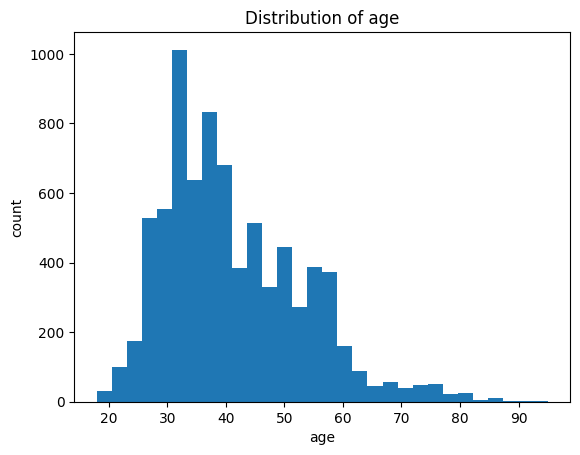

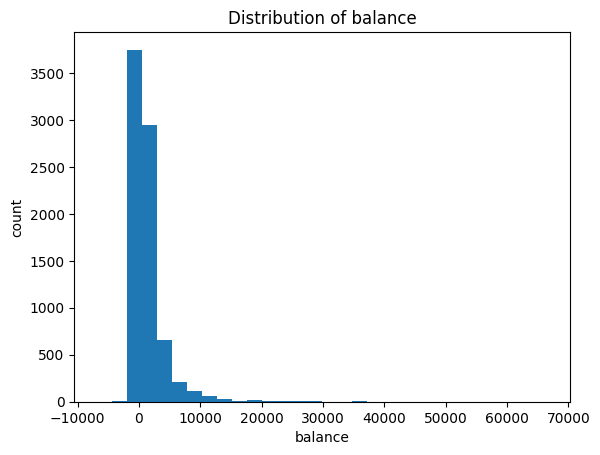

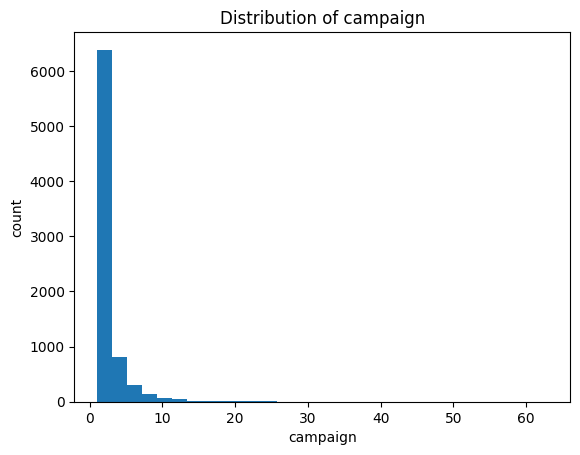

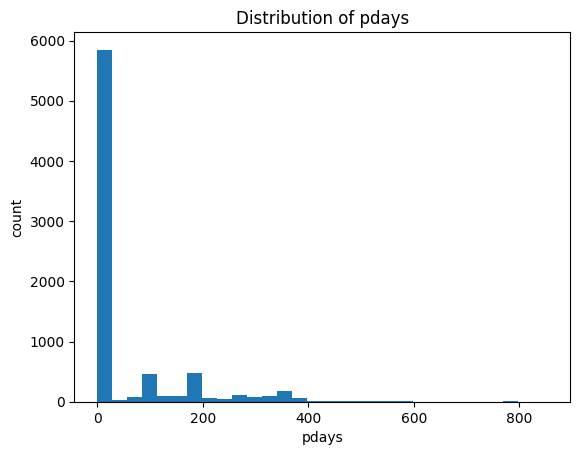

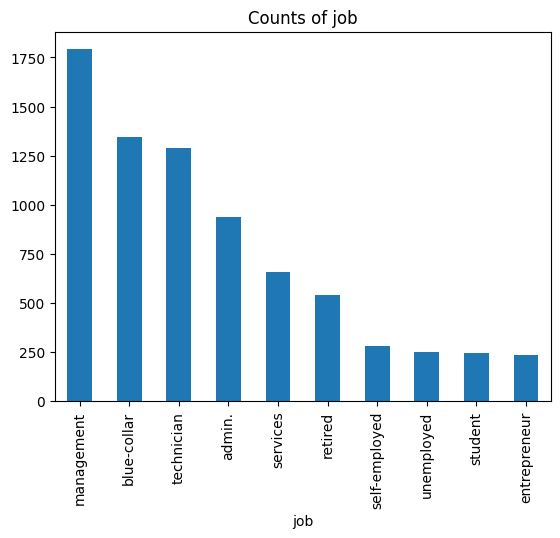

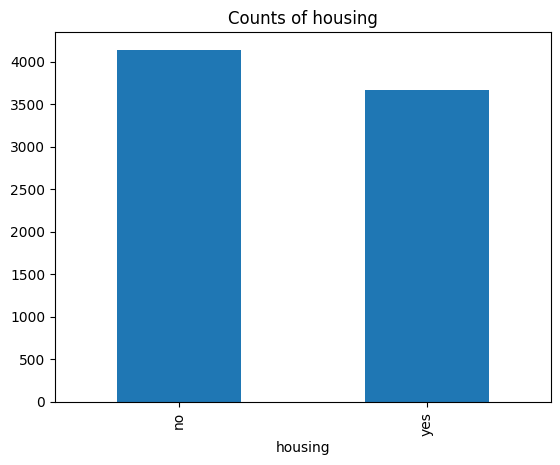

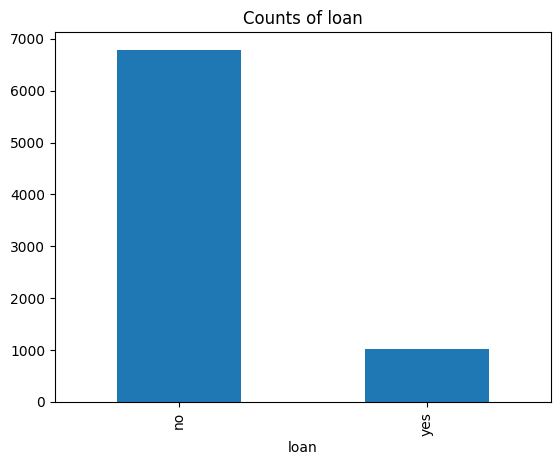

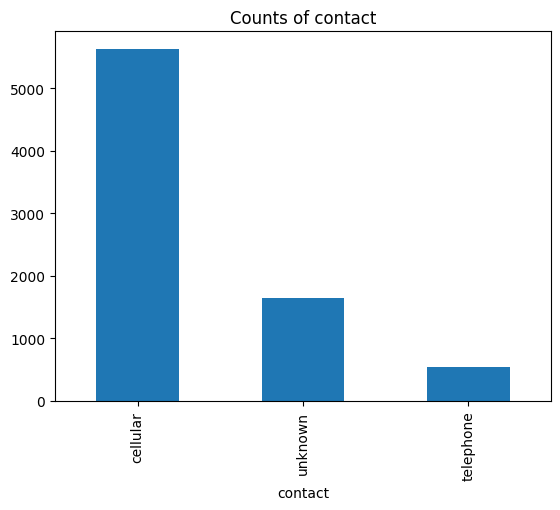

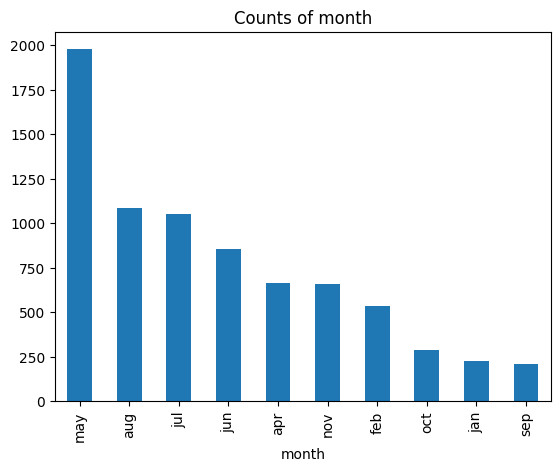

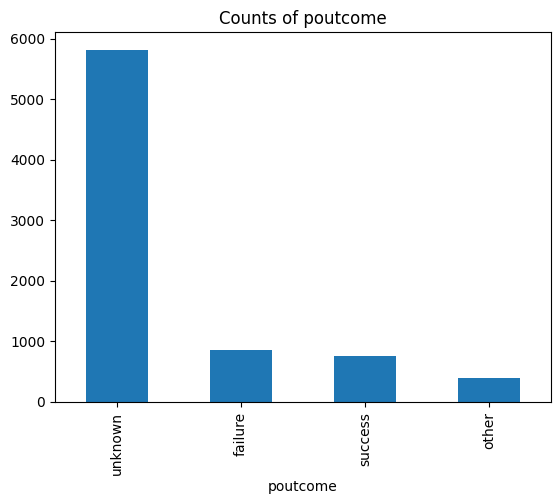

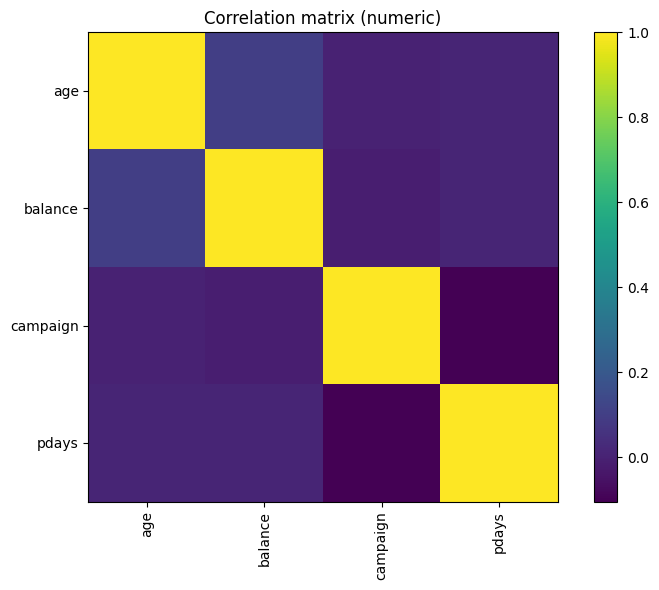

In [4]:
import matplotlib.pyplot as plt
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

for i, c in enumerate(num_cols[:6]):
    plt.figure()
    plt.hist(X[c].dropna(), bins=30)
    plt.title(f'Distribution of {c}')
    plt.xlabel(c)
    plt.ylabel('count')
    plt.show()

for c in cat_cols[:6]:
    plt.figure()
    X[c].value_counts().head(10).plot(kind='bar')
    plt.title(f'Counts of {c}')
    plt.show()

if len(num_cols) > 1:
    corr = X[num_cols].corr()
    plt.figure(figsize=(8,6))
    plt.imshow(corr, cmap='viridis')
    plt.colorbar()
    plt.title('Correlation matrix (numeric)')
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.tight_layout()
    plt.show()


## E. Feature Engineering & Selection

Example checks for date columns and create feature importance later.

In [5]:
# Example: check for date-like columns
for c in X.columns:
    if 'date' in c.lower() or 'day' in c.lower() or 'month' in c.lower():
        print('Potential date-like column:', c)

# Feature importance will be shown from RandomForest model later.


Potential date-like column: month
Potential date-like column: pdays


## F. Modeling & Evaluation

Train baseline models and evaluate using appropriate metrics.

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix

models = {}
if 'classification' == 'classification':
    models['LogisticRegression'] = LogisticRegression(max_iter=1000)
    models['RandomForest'] = RandomForestClassifier(n_estimators=200, random_state=42)
    models['GradientBoosting'] = GradientBoostingClassifier(n_estimators=200, random_state=42)
else:
    models['LinearRegression'] = LinearRegression()
    models['RandomForestRegressor'] = RandomForestRegressor(n_estimators=200, random_state=42)
    models['GradientBoostingRegressor'] = GradientBoostingRegressor(n_estimators=200, random_state=42)

fitted = {}
for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    fitted[name] = pipe
    print('Trained', name)

for name, pipe in fitted.items():
    y_pred = pipe.predict(X_test)
    print('\nModel:', name)
    if 'classification' == 'classification':
        try:
            y_scores = pipe.predict_proba(X_test)[:,1]
        except Exception:
            y_scores = None
        print(classification_report(y_test, y_pred, zero_division=0))
        print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))
    else:
        from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
        mse = mean_squared_error(y_test, y_pred)
        print('MAE:', mean_absolute_error(y_test, y_pred))
        print('RMSE:', mse**0.5)
        print('R2:', r2_score(y_test, y_pred))


Trained LogisticRegression
Trained RandomForest
Trained GradientBoosting

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.76      0.55      0.64       747
           1       0.67      0.84      0.75       816

    accuracy                           0.70      1563
   macro avg       0.72      0.70      0.69      1563
weighted avg       0.71      0.70      0.69      1563

Confusion matrix:
 [[412 335]
 [131 685]]

Model: RandomForest
              precision    recall  f1-score   support

           0       0.72      0.63      0.67       747
           1       0.70      0.77      0.73       816

    accuracy                           0.71      1563
   macro avg       0.71      0.70      0.70      1563
weighted avg       0.71      0.71      0.70      1563

Confusion matrix:
 [[473 274]
 [185 631]]

Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.77      0.60      0.67       747
       

### G. Hyperparameter Tuning (example for RandomForest)

In [9]:
from sklearn.model_selection import GridSearchCV

if 'classification' == 'classification':
    estimator = Pipeline(steps=[('preprocessor', preprocessor), ('model', RandomForestClassifier(random_state=42))])
    param_grid = {'model__n_estimators':[100,200], 'model__max_depth':[None,10,20]}
else:
    estimator = Pipeline(steps=[('preprocessor', preprocessor), ('model', RandomForestRegressor(random_state=42))])
    param_grid = {'model__n_estimators':[100,200], 'model__max_depth':[None,10,20]}

gs = GridSearchCV(estimator, param_grid, cv=3, scoring='roc_auc' if 'classification'=='classification' else 'r2', n_jobs=-1)
try:
    gs.fit(X_train, y_train)
    print('Best params:', gs.best_params_)
    best = gs.best_estimator_
    y_pred = best.predict(X_test)
    print('\nTuned model evaluation:')
    if 'classification' == 'classification':
        from sklearn.metrics import classification_report
        print(classification_report(y_test, y_pred, zero_division=0))
    else:
        from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
        mse = mean_squared_error(y_test, y_pred)
        print('MAE:', mean_absolute_error(y_test, y_pred))
        print('RMSE:', mse**0.5)
        print('R2:', r2_score(y_test, y_pred))
except Exception as e:
    print('Grid search failed or skipped:', e)


Best params: {'model__max_depth': 10, 'model__n_estimators': 100}

Tuned model evaluation:
              precision    recall  f1-score   support

           0       0.79      0.59      0.67       747
           1       0.69      0.85      0.77       816

    accuracy                           0.73      1563
   macro avg       0.74      0.72      0.72      1563
weighted avg       0.74      0.73      0.72      1563



## H. Conclusions & Recommendations

Summarize final findings, model limitations, how/when the model should be used, and next steps for improvement.

### Conclusions
- This project aimed to develop a machine learning model to predict whether a customer would subscribe to a bank term deposit based on historical marketing campaign data. Several classification algorithms were evaluated, including Logistic Regression and Random Forest, using metrics aligned with the business objective.

- Based on the evaluation results, Logistic Regression was selected as the final model. Although Random Forest achieved slightly higher overall accuracy, Logistic Regression delivered better recall (0.84) and F1-score (0.75) for the positive class (subscribed customers). Since the primary business objective is to identify as many potential subscribers as possible and reduce missed opportunities, recall was prioritized over accuracy.

- The final Logistic Regression model successfully identifies a large proportion of customers who are likely to subscribe, while maintaining acceptable precision. This makes the model suitable for supporting targeted marketing decisions, enabling the bank to focus its resources on customers with higher conversion potential

### Business Impact
- By implementing this model, the marketing team can:

- Reduce campaign costs by targeting customers with higher predicted subscription likelihood.

- Increase conversion rates by minimizing false negatives (missed potential subscribers).

- Improve overall campaign efficiency and return on investment (ROI).

- Based on the test results, the model is able to correctly identify approximately 84% of customers who will subscribe, which represents a significant improvement over untargeted marketing approaches.

### Recommendations
- The model should be used as a decision-support tool, not as an automated decision maker.

- Marketing teams should prioritize customers predicted as class 1 (likely to subscribe) for outreach campaigns.

- Logistic Regression is recommended due to its interpretability, allowing stakeholders to understand which customer attributes influence subscription decisions.

- The decision threshold can be adjusted depending on campaign strategy:

- Lower threshold → higher recall (aggressive campaign)

- Higher threshold → higher precision (cost-sensitive campaign)

### Limitations
- The model is trained on historical data and may underperform if customer behavior or marketing strategies change significantly (concept drift).

- Some customer attributes that may influence subscription decisions (e.g., income level, digital behavior, or customer lifetime value) are not available in the dataset.

- Class imbalance may still affect prediction reliability in extreme cases.

### Next steps
- Collect additional customer behavior and demographic features to improve predictive power.

- Apply advanced techniques such as class-weight tuning, threshold optimization, or ensemble methods.

- Perform regular model retraining and monitoring to maintain performance over time.

- Evaluate the model using real campaign outcomes through A/B testing before full deployment


## Appendix: Quick Results Summary 

- Dataset shape: (7813, 11)\n
- Target column: `deposit` (classification)\n
- Missing values (columns with >0):\n
```
{}
```

- Duplicate rows: 8\n
- Numeric columns: ['age', 'balance', 'campaign', 'pdays']\n
- Categorical columns: ['job', 'housing', 'loan', 'contact', 'month', 'poutcome']\n
### Model results (test set):\n
**LogisticRegression**:\n
- accuracy: 0.7018554062699937\n
- precision: 0.6715686274509803\n
- recall: 0.8394607843137255\n
- f1: 0.7461873638344226\n
- roc_auc: 0.7592207063548312\n
- confusion_matrix: [[412, 335], [131, 685]]\n
\n**RandomForest**:\n
- accuracy: 0.7063339731285988\n
- precision: 0.6972375690607735\n
- recall: 0.7732843137254902\n
- f1: 0.7332945961650204\n
- roc_auc: 0.7587597120508177\n
- confusion_matrix: [[473, 274], [185, 631]]\n
\n**GradientBoosting**:\n
- accuracy: 0.7216890595009597\n
- precision: 0.6953846153846154\n
- recall: 0.8308823529411765\n
- f1: 0.7571189279731994\n
- roc_auc: 0.7774570504239179\n
- confusion_matrix: [[450, 297], [138, 678]]\n
\n

### I. Post-Modeling Exploratory Data Analysis (Model Interpretation & Insights)
Objective

This post-modeling EDA aims to:

- Understand why the model makes certain predictions

- Identify key features influencing customer subscription

- Translate model outputs into actionable business insights

1 Feature Importance Analysis (Logistic Regression Coefficients)
Why?

- Logistic Regression provides interpretable coefficients that explain:

- Direction of influence (positive / negative)

- Strength of each feature on subscription probability

In [11]:
# Get trained objects
log_reg = fitted['LogisticRegression'].named_steps['model']
preprocessor = fitted['LogisticRegression'].named_steps['preprocessor']

# Get feature names directly from ColumnTransformer
feature_names = preprocessor.get_feature_names_out()

# Clean feature names (optional but nicer)
feature_names = [f.replace('num__', '').replace('cat__', '') for f in feature_names]

# Create coefficient dataframe
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': log_reg.coef_[0]
}).sort_values(by='coefficient', ascending=False)

coef_df.head(10)


,feature,coefficient
27,month_jan,1.036417
22,contact_unknown,0.775188
32,month_nov,0.774045
24,month_aug,0.689290
38,poutcome_unknown,0.635813
28,month_jul,0.583840
35,poutcome_failure,0.557162
26,month_feb,0.430610
15,job_unknown,0.356456
31,month_may,0.344963


Interpretation: 

- Features with positive coefficients increase the likelihood of subscription.

- Features with negative coefficients decrease the likelihood of subscription.

- The magnitude of coefficients indicates the strength of influence.

2. Top Positive & Negative Drivers.
- Visualization

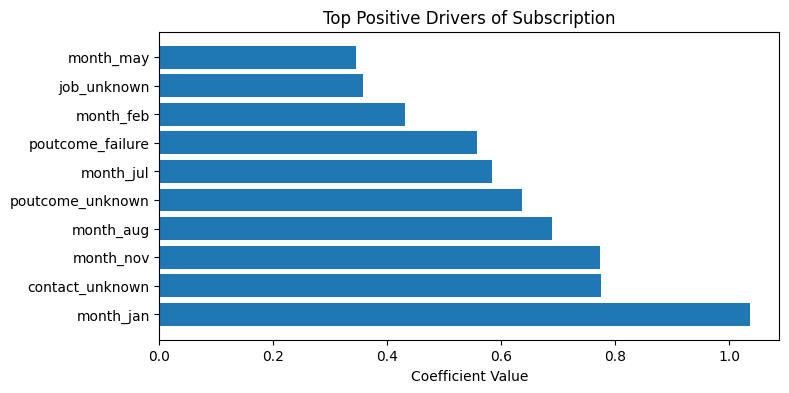

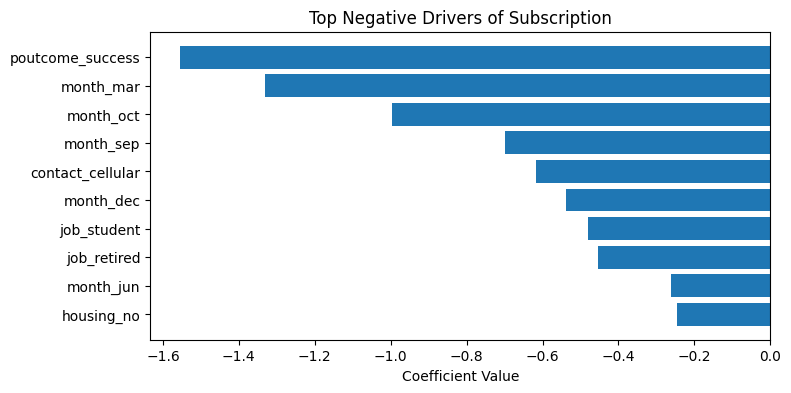

In [12]:
top_positive = coef_df.head(10)
top_negative = coef_df.tail(10)

plt.figure(figsize=(8,4))
plt.barh(top_positive['feature'], top_positive['coefficient'])
plt.title('Top Positive Drivers of Subscription')
plt.xlabel('Coefficient Value')
plt.show()

plt.figure(figsize=(8,4))
plt.barh(top_negative['feature'], top_negative['coefficient'])
plt.title('Top Negative Drivers of Subscription')
plt.xlabel('Coefficient Value')
plt.show()

Customers contacted through certain channels or during specific months show a higher likelihood of subscribing, while customers with multiple previous failed contacts show a lower likelihood.

3. Probability Distribution Analysis.
Why?

- This shows how confident the model is and helps with threshold tuning

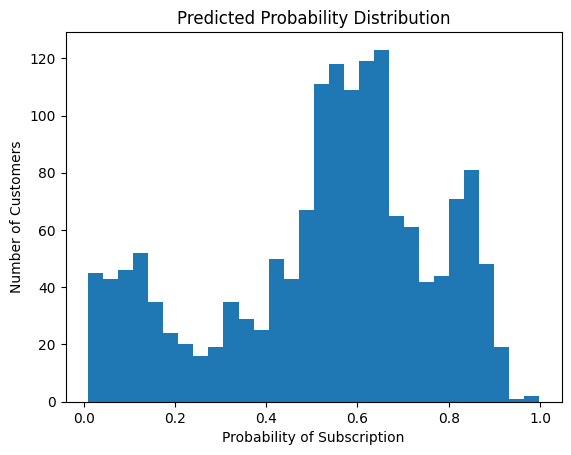

In [13]:
y_prob = fitted['LogisticRegression'].predict_proba(X_test)[:,1]

plt.figure()
plt.hist(y_prob, bins=30)
plt.title('Predicted Probability Distribution')
plt.xlabel('Probability of Subscription')
plt.ylabel('Number of Customers')
plt.show()

Interpretation:

- A clear separation indicates strong model confidence.

- Overlapping probabilities suggest uncertainty and potential threshold optimization.

4. False Negative Analysis (Critical Business Insight)
Why?

- False negatives = missed potential customers
- This is crucial for bank marketing.

In [14]:
y_pred = fitted['LogisticRegression'].predict(X_test)

results_df = X_test.copy()
results_df['actual'] = y_test.values
results_df['predicted'] = y_pred

false_negatives = results_df[
    (results_df['actual'] == 1) & (results_df['predicted'] == 0)
]

false_negatives.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,actual,predicted
1878,40,blue-collar,2129,yes,no,cellular,apr,3,-1,unknown,1,0
6059,30,services,803,no,no,cellular,apr,1,-1,unknown,1,0
5351,38,management,0,no,no,cellular,sep,12,197,failure,1,0
760,30,blue-collar,1012,yes,no,cellular,apr,3,329,failure,1,0
5478,59,retired,20,no,no,cellular,jul,1,-1,unknown,1,0


Business Interpretation:

- Analyze characteristics of missed subscribers.

- These customers can be targeted using alternative campaign strategies or incentives

In [ ]:
print('Notebook created by script.')

Notebook created by script.
